# Adversarial Robustness

This notebook implements some attacks and defense methods to a CNN classifier for the mnist dataset.

All methods are from the Adversarial Robustness Toolbox (ART): https://github.com/Trusted-AI/adversarial-robustness-toolbox

In [38]:
!pip install adversarial-robustness-toolbox

In [42]:
from __future__ import absolute_import, division, print_function, unicode_literals

from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

import numpy as np
import matplotlib.pyplot as plt

from art import config
from art.utils import load_dataset
from art.attacks.evasion import FastGradientMethod, AdversarialPatch
from art.defences.trainer import AdversarialTrainer
from art.estimators.classification import KerasClassifier
from art.metrics import empirical_robustness

## 0. Model training

In [43]:
# Read MNIST dataset
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset(str("mnist"))

In [45]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

In [46]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [47]:
classifier = KerasClassifier(model=model, clip_values=(min_, max_))
classifier.fit(x_train, y_train, nb_epochs=5, batch_size=128)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 137s 2ms/sample - loss: 0.2567 - accuracy: 0.9204
Epoch 2/5
60000/60000 [==============================] - 137s 2ms/sample - loss: 0.0887 - accuracy: 0.9736
Epoch 3/5
60000/60000 [==============================] - 137s 2ms/sample - loss: 0.0653 - accuracy: 0.9799
Epoch 4/5
60000/60000 [==============================] - 137s 2ms/sample - loss: 0.0519 - accuracy: 0.9844
Epoch 5/5
60000/60000 [==============================] - 137s 2ms/sample - loss: 0.0465 - accuracy: 0.9852


## 0.1 Evaluate model on test set

In [48]:
# Evaluate the classifier on the test set
preds = np.argmax(classifier.predict(x_test), axis=1)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("Test accuracy: %.2f%%" % (acc * 100))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Test accuracy: 98.95%


# 1. Adversarial attacks

## 1.1 Craft adversarial samples with FastGradientMethod

In [49]:
epsilon = 0.2  # Maximum perturbation
adv_crafter = FastGradientMethod(classifier, eps=epsilon)
x_test_adv = adv_crafter.generate(x=x_test)

In [50]:
# Evaluate the classifier on the adversarial examples
preds = np.argmax(classifier.predict(x_test_adv), axis=1)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("\nTest accuracy on adversarial sample: %.2f%%" % (acc * 100))


Test accuracy on adversarial sample: 41.23%


### 1.1.1 Plot true and adversarial examples

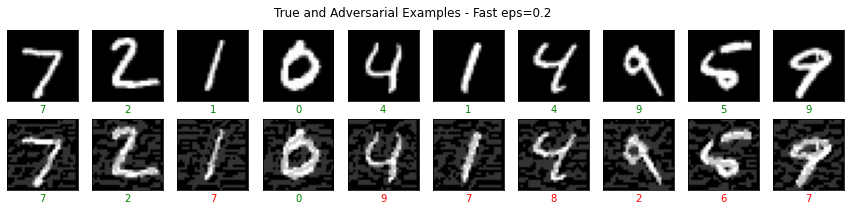

In [51]:
x_orig = ((x_test    ) * 255).astype('int')[:, :, :, 0]
x_adv  = ((x_test_adv) * 255).astype('int')[:, :, :, 0]

y_pred_orig = classifier.predict(x_test,    verbose=0)
y_pred_adv  = classifier.predict(x_test_adv, verbose=0)

fig    = plt.figure(figsize=(15, 3))
cols   = 10
rows   = 2
images = list(x_orig[:cols])      + list(x_adv[:cols])
preds  = list(y_pred_orig[:cols]) + list(y_pred_adv[:cols])
labels = list(y_test[:cols])      + list(y_test[:cols])

fig.suptitle('True and Adversarial Examples - Fast eps=0.2')

for i in range(0, len(images)):
    ax = fig.add_subplot(rows, cols, i+1)
    y_pred = np.argmax(preds[i])
    y_orig = np.argmax(labels[i])
    ax.set_xlabel(y_pred,
                  color = "green" if y_pred == y_orig else "red")
    ax.tick_params(axis='both', which='both',
                   bottom=False, top=False,
                   right=False, left=False,
                   labelbottom=False, labelleft=False)
    plt.imshow(images[i], cmap='gray')


plt.show()

### 1.1.2 Calculate adversarial accuracy for different epsilons

In [52]:
accuracies = []

for epsilon in np.arange(0.1, 0.5, 0.05):
#epsilon = 0.2  # Maximum perturbation
  adv_crafter = FastGradientMethod(classifier, eps=epsilon)
  x_test_adv = adv_crafter.generate(x=x_test)

  preds = np.argmax(classifier.predict(x_test_adv), axis=1)
  acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
  accuracies.append(acc)

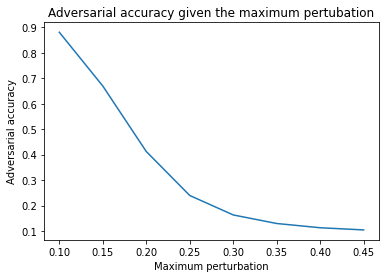

In [53]:
plt.plot(np.arange(0.1, 0.5, 0.05), accuracies)
plt.title("Adversarial accuracy given the maximum pertubation")
plt.xlabel("Maximum perturbation")
plt.ylabel("Adversarial accuracy")
plt.show()

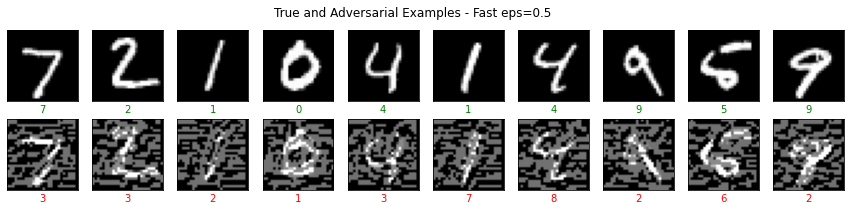

In [54]:
x_orig = ((x_test    ) * 255).astype('int')[:, :, :, 0]
x_adv  = ((x_test_adv) * 255).astype('int')[:, :, :, 0]

y_pred_orig = classifier.predict(x_test,    verbose=0)
y_pred_adv  = classifier.predict(x_test_adv, verbose=0)

fig    = plt.figure(figsize=(15, 3))
cols   = 10
rows   = 2
images = list(x_orig[:cols])      + list(x_adv[:cols])
preds  = list(y_pred_orig[:cols]) + list(y_pred_adv[:cols])
labels = list(y_test[:cols])      + list(y_test[:cols])

fig.suptitle('True and Adversarial Examples - Fast eps=0.5')

for i in range(0, len(images)):
    ax = fig.add_subplot(rows, cols, i+1)
    y_pred = np.argmax(preds[i])
    y_orig = np.argmax(labels[i])
    ax.set_xlabel(y_pred,
                  color = "green" if y_pred == y_orig else "red")
    ax.tick_params(axis='both', which='both',
                   bottom=False, top=False,
                   right=False, left=False,
                   labelbottom=False, labelleft=False)
    plt.imshow(images[i], cmap='gray')


plt.show()

## 1.2 Craft adversarial samples with DeepFool

In [74]:
adv_crafter = DeepFool(classifier)
x_test_adv_df = adv_crafter.generate(x_test)

preds = np.argmax(classifier.predict(x_test_adv_df), axis=1)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("\nTest accuracy on adversarial sample: %.2f%%" % (acc * 100))

DeepFool:   0%|          | 0/10000 [00:00<?, ?it/s]


Test accuracy on adversarial sample: 11.64%


### 1.2.1 Plot true and adversarial examples

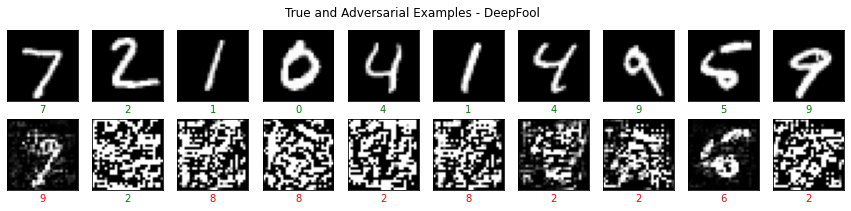

In [75]:
x_orig = ((x_test    ) * 255).astype('int')[:, :, :, 0]
x_adv  = ((x_test_adv_df) * 255).astype('int')[:, :, :, 0]

y_pred_orig = classifier.predict(x_test,    verbose=0)
y_pred_adv  = classifier.predict(x_test_adv_df, verbose=0)

fig    = plt.figure(figsize=(15, 3))
cols   = 10
rows   = 2
images = list(x_orig[:cols])      + list(x_adv[:cols])
preds  = list(y_pred_orig[:cols]) + list(y_pred_adv[:cols])
labels = list(y_test[:cols])      + list(y_test[:cols])

fig.suptitle('True and Adversarial Examples - DeepFool')

for i in range(0, len(images)):
    ax = fig.add_subplot(rows, cols, i+1)
    y_pred = np.argmax(preds[i])
    y_orig = np.argmax(labels[i])
    ax.set_xlabel(y_pred,
                  color = "green" if y_pred == y_orig else "red")
    ax.tick_params(axis='both', which='both',
                   bottom=False, top=False,
                   right=False, left=False,
                   labelbottom=False, labelleft=False)
    plt.imshow(images[i], cmap='gray')


plt.show()

# 2. Adversarial defense


## 2.1 Train Robust Classifier

Train robust classifier with BasicIterativeMethod:

In [61]:
robust_classifier = classifier

attacker = FastGradientMethod(classifier, eps=0.2)

trainer = AdversarialTrainer(robust_classifier, attacker, ratio=1.0)
trainer.fit(x_train, y_train, nb_epochs=5, batch_size=128)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Create attackers:

In [62]:
attacker_robust = FastGradientMethod(robust_classifier, eps=0.2)
x_test_adv_robust = attacker_robust.generate(x_test)

#attacker = FastGradientMethod(classifier, eps=0.2)
x_test_adv = attacker.generate(x=x_test)

## 2.2 Evaluate the robust classifier

In [63]:
preds = np.argmax(robust_classifier.predict(x_test), axis=1)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("Test accuracy: %.2f%%" % (acc * 100))

preds = np.argmax(robust_classifier.predict(x_test_adv_robust), axis=1)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("Adversarial test accuracy: %.2f%%" % (acc * 100))

Test accuracy: 99.06%
Adversarial test accuracy: 96.33%


## 2.3 Compare original and robust classifiers

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if sys.path[0] == '':


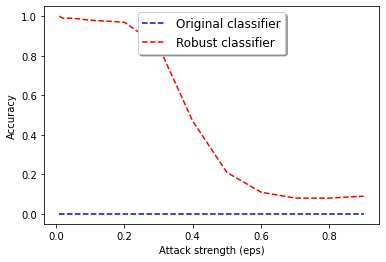

In [73]:
eps_range = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
acc_original = []
acc_robust = []

for eps in eps_range:
    attacker.set_params(**{'eps': eps})
    attacker_robust.set_params(**{'eps': eps})
    x_test_adv = attacker.generate(x_test[:100])
    x_test_adv_robust = attacker_robust.generate(x_test[:100])
    
    x_test_adv_pred = np.argmax(classifier.predict(x_test_adv), axis=1)
    acc_original += [np.sum(preds == np.argmax(y_test[:100], axis=1)) / 100]
    
    x_test_adv_robust_pred = np.argmax(robust_classifier.predict(x_test_adv_robust), axis=1)
    acc_robust += [np.sum(x_test_adv_robust_pred == np.argmax(y_test[:100], axis=1)) / 100]

eps_range = eps_range

fig, ax = plt.subplots()
ax.plot(np.array(eps_range), np.array(acc_original), 'b--', label='Original classifier')
ax.plot(np.array(eps_range), np.array(acc_robust), 'r--', label='Robust classifier')

legend = ax.legend(loc='upper center', shadow=True, fontsize='large')

plt.xlabel('Attack strength (eps)')
plt.ylabel('Accuracy')
plt.show()